# NoteBook final que Monta a Árvore de Decisão

Importa a bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier
import pydotplus 
from IPython.display import Image

Carregamento do arquivo e faz os seguintes tratamento de dados:


*   Remove registros Nulos
*   Remove regitros Inválidos
*   Substitui valores nulos por zero
*   Cria campo de diferança.   

In [ ]:
#ler a planilha com os dados iniciais, e carrega o DataFrame
pd_dados = pd.read_excel("/content/sample_data/TCC_Dados_Final1_ni.xlsx", sheet_name=0)     
        
print("\nRemovendo registros nulos do arquivo")
# dropna remove os registros faltantes    
pd_dados.dropna(axis=0, subset=['sit_cadastral'], inplace = True) 
pd_dados.dropna(axis=0, subset=['cnae3'], inplace = True)
pd_dados.dropna(axis=0, subset=['ni'], inplace = True)

print("\nRemovendo registros inválidos do arquivo")
#Remove registros que tem CNAE Inválido ou Não Informado
pd_dados['sit_cadastral'] = pd_dados['sit_cadastral'].astype('str')
pd_dados = pd_dados[~pd_dados['sit_cadastral'].str.contains('NULA')]

#Remove registros que tem CNAE Inválido ou Não Informado
pd_dados['cnae3'] = pd_dados['cnae3'].astype('str')
pd_dados = pd_dados[~pd_dados['cnae3'].str.contains('IN')]
pd_dados = pd_dados[~pd_dados['cnae3'].str.contains('NI')]

print("\nSubstitui valores nulos por Zero para os campos de Débitos")
#Coloca zero quando não tem valor, para não dá erro no calculo da diferença. Quando está nulo é por que não tem mais débito, ou seja, está zerado
pd_dados[['valorm1']] = pd_dados[['valorm1']].fillna(value = 0)
pd_dados[['valorm3']] = pd_dados[['valorm3']].fillna(value = 0)

print("\nCriando campos de comparação")
#calcula os campos de comparação para saber se o débito aumentou o diminuiu
pd_dados["Dif1"] = pd_dados.valorm1 - pd_dados.valor
pd_dados["Dif3"] = pd_dados.valorm3 - pd_dados.valor

pd_dados = pd_dados.loc[pd_dados['Dif1'] > 10]

print("\nSalvando o arquivo: {0}".format("/content/sample_data/TCC_Dados_Final1_ni_Aumentou.xlsx"))
pd_dados.to_excel("/content/sample_data/TCC_Dados_Final1_ni_Aumentou.xlsx", index=False)


Removendo registros nulos do arquivo

Removendo registros inválidos do arquivo


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()



Substitui valores nulos por Zero para os campos de Débitos

Criando campos de comparação

Salvando o arquivo: /content/sample_data/TCC_Dados_Final1_ni_Aumentou.xlsx


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Função que define a Classificação em:

*   Aumentou_500 - débito subiu mais que 500 reais
*   Aumentou_10 - débito subiu entre 10 e 500 reais
*   Não aumentou - débito que não teve um aumento maior que 10 reais





In [ ]:
def encode_units(x):
  if x > 500:
    return "Aumentou_500"
  elif x > 10:
    return "Aumentou_10"
  else:
      return "Não Aumentou"


Campos/Atributos do Modelo a ser treinado

    0 - ni	
    1 - classe	
    2 - sit_cadastral	
    3 - diferenciada	
    4 - simei	
    5 - simples	
    6 - porte	
    7 - nat_juridica	
    8 - cnae3	
    9 - valor
    10 - valorm1	
    11 - valorm3	
    12 - Dif1
    13 - Dif3

Treinamendo de Modelo Particionando a árvore e com Hiperparâmetros pre-definidos

In [ ]:
#carrega o arquivo já tratado anteriormente para o DataFrame
pd_debitos = pd.read_excel("/content/sample_data/TCC_Dados_Final1_ni_Aumentou.xlsx", sheet_name=0) 

#Tranforma os valores de diferença usando o método encode_units
pd_debitos["Dif1"] = pd_debitos["Dif1"].apply(encode_units)
pd_debitos["Dif3"] = pd_debitos["Dif3"].apply(encode_units)

#apaga os valores sem diferença, manteve o débito igual
pd_debitos.dropna(axis=0, subset=['Dif1'], inplace = True)
pd_debitos.dropna(axis=0, subset=['Dif3'], inplace = True)

#cria o array dos campos que ainda precisam fazer o encoder, depois para cada campo faz o encoder
arr_atributos =['classe','sit_cadastral', 'diferenciada', 'simei','simples', 'porte', 'nat_juridica', 'cnae3'] 
le = LabelEncoder() 
for atributo in arr_atributos:
    pd_debitos.sort_values(by=atributo, inplace = True)
    pd_debitos[atributo] = le.fit_transform(pd_debitos[atributo]) 
    print(pd_debitos[atributo].sort_values().unique().tolist())
    print(le.inverse_transform(pd_debitos[atributo].sort_values().unique().tolist()))


#define a coluna de resultado
y_dados_m3 = le.fit_transform(pd_debitos.iloc[:,13:14])
arr_label = le.inverse_transform([0,1,2])
print(le.inverse_transform([0,1,2]))

X_dados = pd_debitos.iloc[:,0:9]

#particiona os dados entre Treinamento e Teste, deixando 1% para treinamento, já que foi o percentual que deu o melhor resultado
X_train, X_test, y_train, y_test = train_test_split(X_dados, y_dados_m3, random_state=0, test_size=0.01)
#cria a arvore de decisão com os HyperParâmetros que apresentaram melhores resultados
debitos_tree = DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_leaf=100, min_samples_split=2000) 

#treina a árvore de decisão
debitos_tree = debitos_tree.fit(X_train, y_train) #comando que irá treinar é o FIT

Train_predict = debitos_tree.predict(X_test) 

#imprime a Acurária encontrada
print("Acurancia Previsão: {0} ".format(accuracy_score(y_test, Train_predict)))
#imprime o relatório de classificação
print(classification_report(y_test, Train_predict, target_names=["Aumentou", "Diminuiu", "Manteve"]))
    
#Imprime a Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, Train_predict)
cnf_table = pd.DataFrame(data=cnf_matrix, index=["Aumentou", "Diminuiu", "Manteve"], columns=["Aumentou (prev)", "Diminuiu (prev)", "Manteve (prev)"])
print(cnf_table)

# Create DOT data
tree.export_graphviz(debitos_tree, out_file="/content/sample_data/TCC_Dados_Final1_ni_Aumentou.dot", 
                                proportion=False,
                                rounded =True,
                                filled=True,
                                feature_names=X_dados.keys(),
                                class_names=arr_label)

[0, 1]
['NPREV' 'PREV']
[0, 1, 2, 3]
['ATIVA' 'BAIXADA' 'INAPTA' 'SUSPENSA']
[0, 1]
['NÃO' 'SIM']
[0, 1]
['NÃO' 'SIM']
[0, 1]
['NÃO' 'SIM']
[0, 1, 2, 3]
['PJ-D' 'PJ-DEMAIS' 'PJ-E' 'PJ-M']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[102 103 106 110 112 115 117 124 133 201 203 204 205 206 207 213 214 215
 223 224 225 230 231 232 306 308 313 322 326 327 399 401]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 1

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurancia Previsão: 0.5691964285714286 
              precision    recall  f1-score   support

    Aumentou       0.71      0.39      0.51       114
    Diminuiu       0.59      0.55      0.57       190
     Manteve       0.51      0.74      0.60       144

    accuracy                           0.57       448
   macro avg       0.60      0.56      0.56       448
weighted avg       0.60      0.57      0.56       448

          Aumentou (prev)  Diminuiu (prev)  Manteve (prev)
Aumentou               45               37              32
Diminuiu               15              104              71
Manteve                 3               35             106


Ler o arquivo DOT com as informações da Árvore criada anteriormente e gera a Imagem

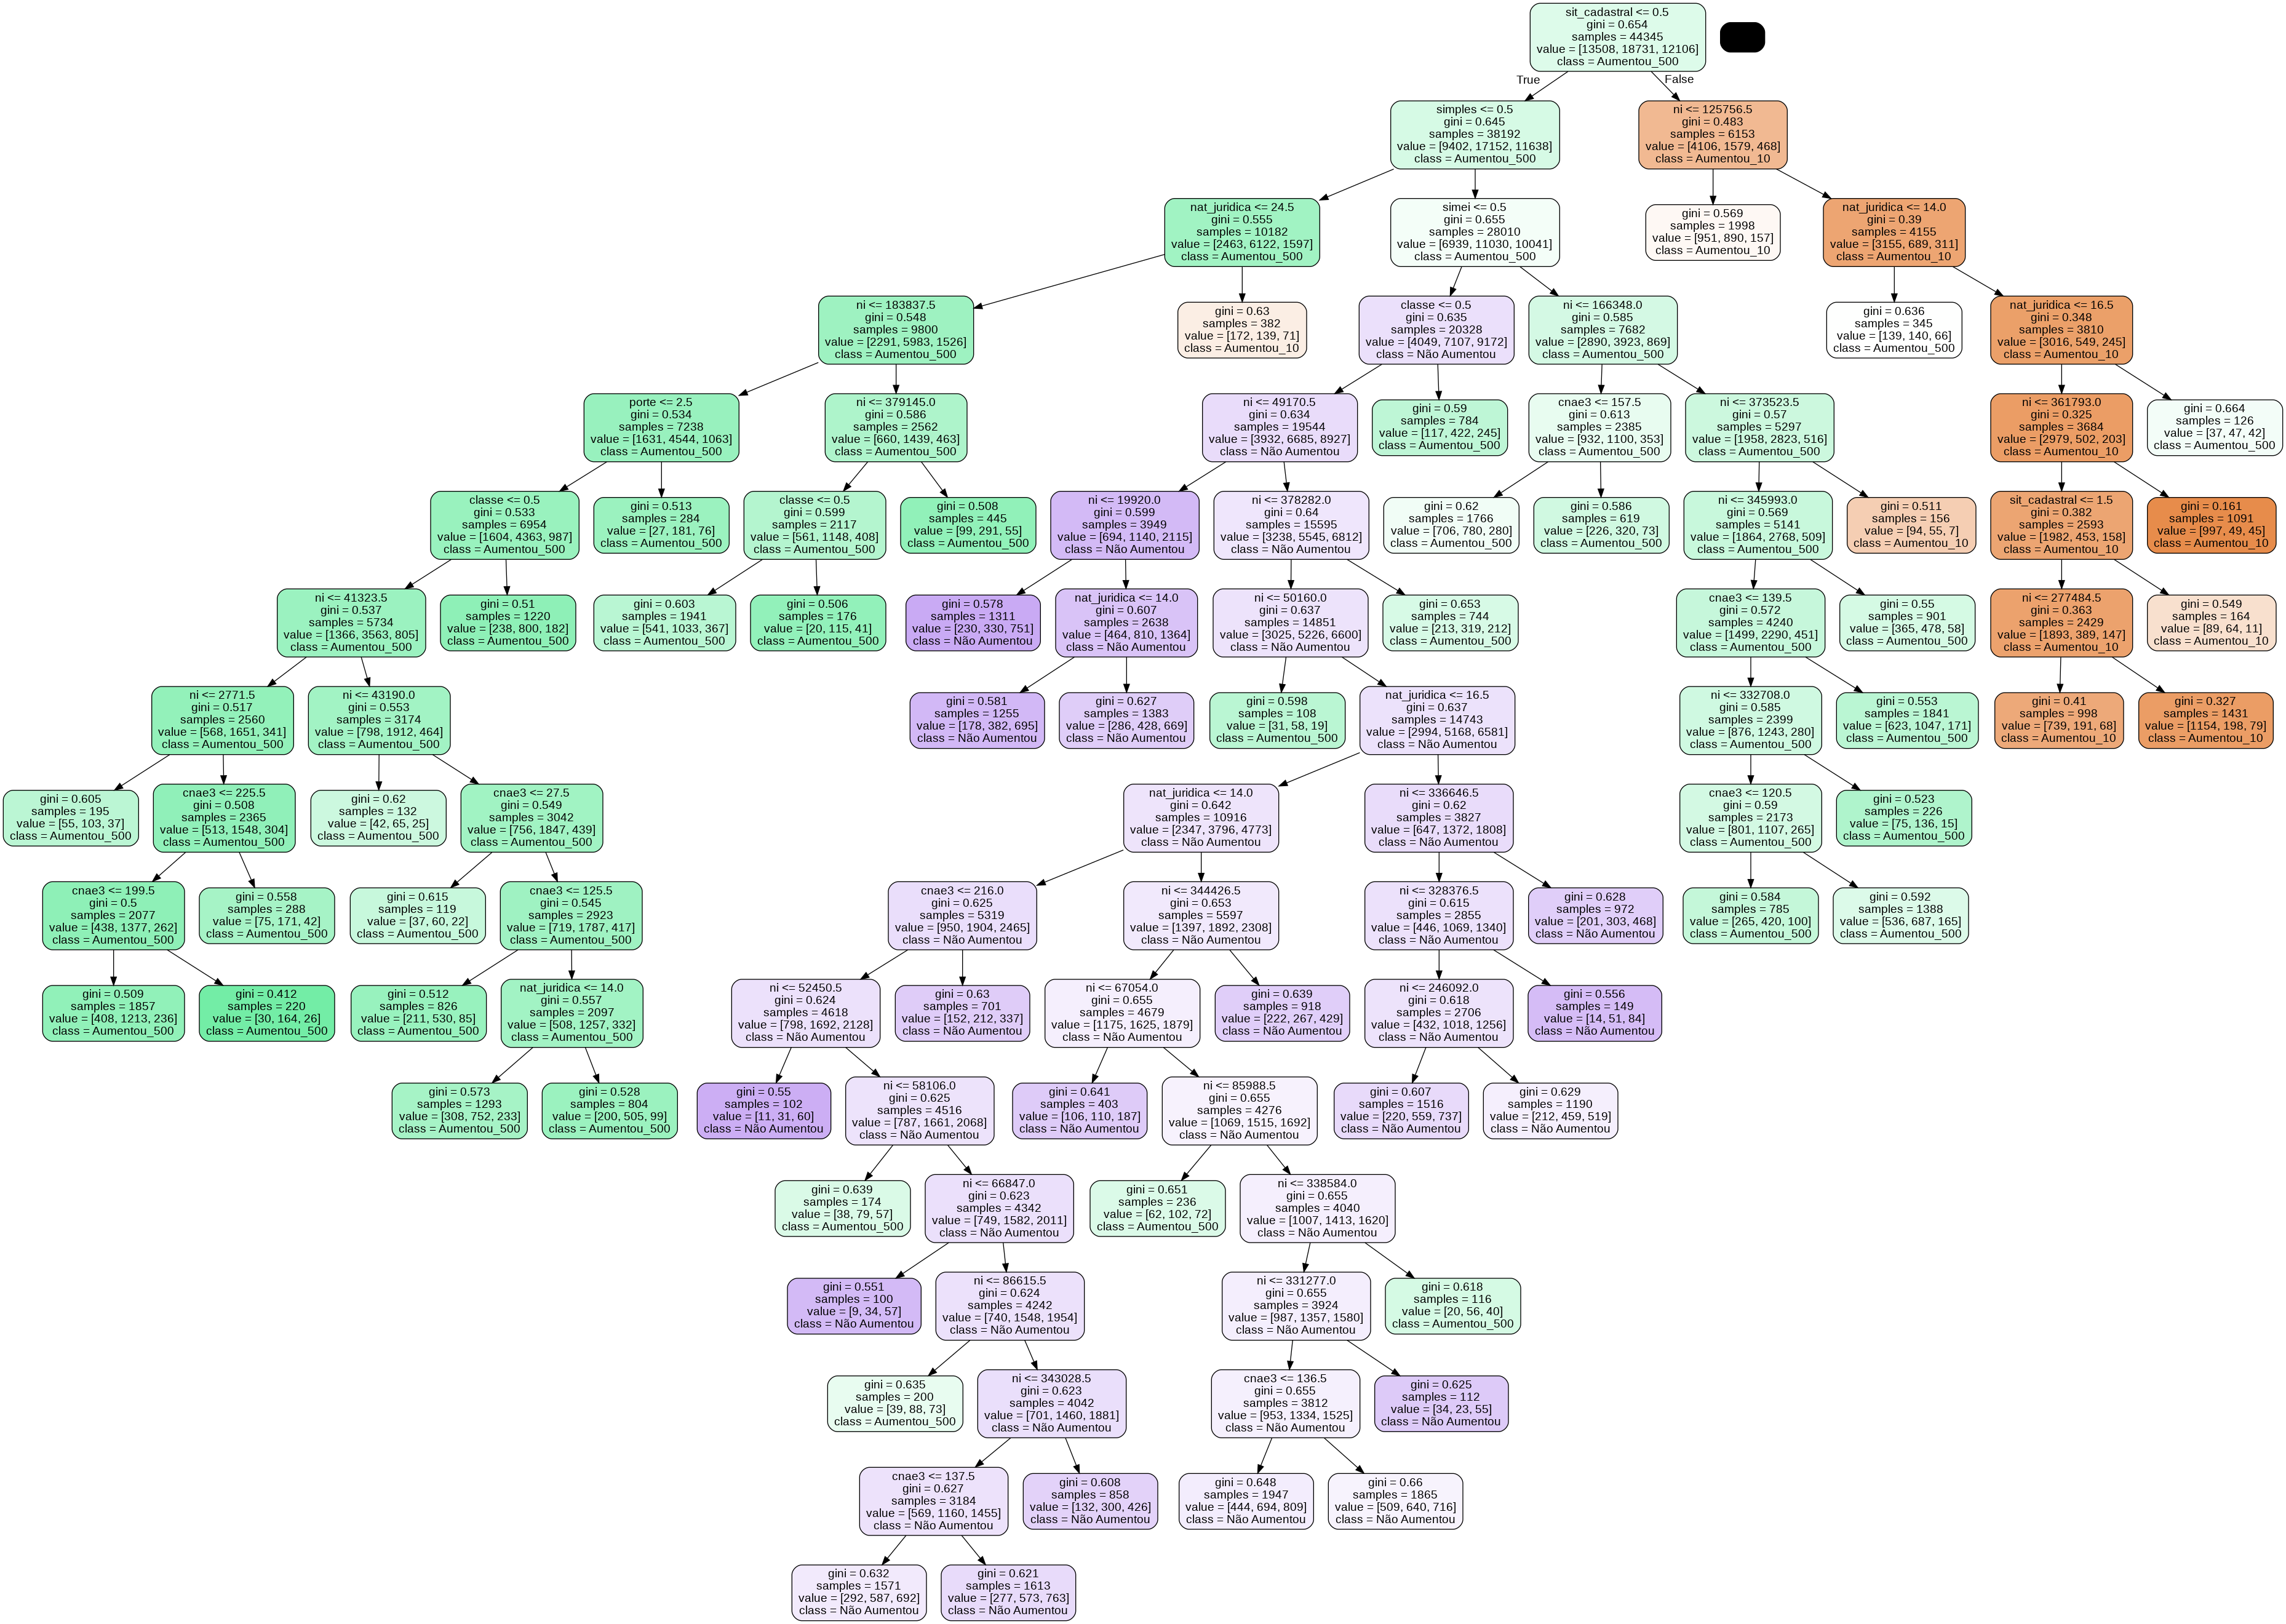

In [ ]:
#ler o arquivo com as informações da árvore
graph = pydotplus.graph_from_dot_file("/content/sample_data/TCC_Dados_Final1_ni_Aumentou.dot")

#salva a imagem
graph.write_png('/content/sample_data/TCC_Dados_Final1_ni_Aumentou.png')

#Mosta a imagem com a Árvore de Decisão
Image(graph.create_png())